###  2.0 EDA

2.1 Setup: Libraries and Data
Initial setup includes loading all necessary libraries and importing the dataset.

2.2 Data Quality Checks
No missing values were found, and only a very small number of duplicate rows were identified.

2.3 Distribution Analysis
Distribution analysis revealed notable differences in feature distributions between exposed and non-exposed groups among those designated for treatment. Specifically:

1.  f0, f3, and f6 showed variation across exposure groups.

2.  f4, f10, and f11 showed the most significant distribution differences between converters and non-converters in the exposed group.

Summary of Key Relationships
Correlation with Target Variables:

*  f4 and f11 had the strongest correlation with conversion.
*  f3 and f6 had the strongest correlation with exposure.

These pairs (f4/f11 and f3/f6) are also highly correlated with one another, suggesting potential redundancy or transformation relationships.

Other Strongly Correlated Pairs:


*  f8 & f9
*  f1 & f5
*  f5 & f7
*  f2 & f9

Feature Engineering Clues:

Four feature pairs have identical mode row locations, and in each case, one feature has significantly fewer unique values than the other. This implies that one feature may be a transformed or binned version of its counterpart:

*  f5 and f7
*  f4 and f10
*  f0 and f6
*  f2 and f8

These findings will guide feature selection and help avoid multicollinearity in later modeling steps.

2.1  Setup: Libraries and Data

In [ ]:
# Install libraries
!pip install numpy
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib
!pip install pandas

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from scipy.stats import ks_2samp
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Sample upload of data
# Saved from previous notebook
df=pd.read_csv('raw_data.csv')
df.head()

2.2 Data Quality checks

In [ ]:
df_filtered.isnull().sum()

,0
f0,0
f1,0
f2,0
f3,0
f4,0
f5,0
f6,0
f7,0
f8,0
f9,0


In [ ]:
# List duplicated rows

duplicates_count = df_filtered.groupby(df_filtered.columns.tolist()).size().reset_index(name='duplicates_count')
df_with_duplicates = pd.merge(df_filtered, duplicates_count, on=df_filtered.columns.tolist(), how='left')
duplicated_rows = df_with_duplicates[df_with_duplicates['duplicates_count'] > 1]
duplicated_rows = duplicated_rows[['duplicates_count'] + duplicated_rows.columns[:-1].tolist()]
duplicated_rows =duplicated_rows.drop_duplicates(keep='first').reset_index(drop=True)
duplicated_rows.shape

(33, 16)

In [ ]:
for col in ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']:
  print(f'{col} {duplicated_rows[col].nunique()}')

f0 1
f1 1
f2 33
f3 1
f4 1
f5 1
f6 1
f7 1
f8 12
f9 12
f10 1
f11 1


There are a total of 33 rows that appear twice in the dataset. The values are the same for most of the factors, with the exception of f2 where they are all unique, and f8 and f9 where there are 12 unique values between the duplicate rows.
Due to not knowing more about what each factor represents nor if these are errors or accurate observations, and the very percentage they represent in the total data set, the duplicates will not be removed.

2.3 Distribution Analysis

Examine distributions and spreads of factors and target variables.  Determine if the spread of factors varies between target groups.

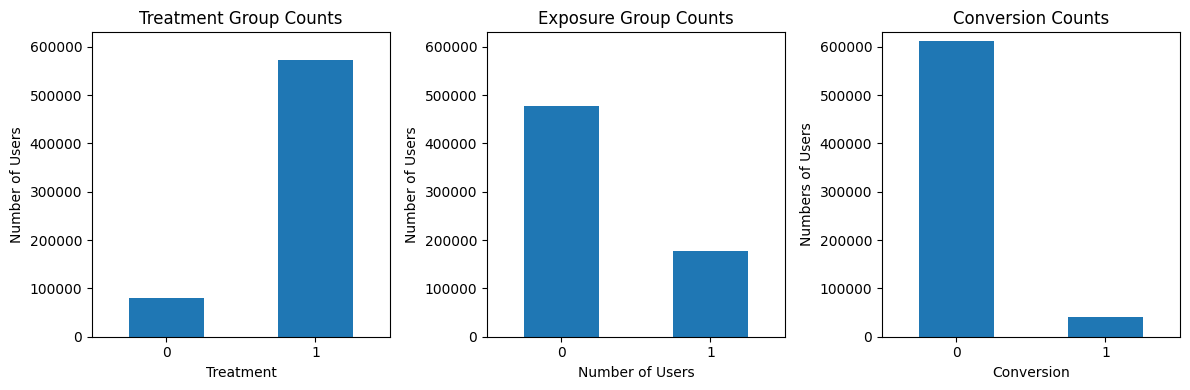

treatment
1    573052
0     80105
Name: count, dtype: int64
exposure
0    476679
1    176478
Name: count, dtype: int64
Percentage of designated users exposed: 27.02%
conversion
0    612501
1     40656
Name: count, dtype: int64
Percentage of designated users converted: 6.22%


In [ ]:
#  Determine value counts for treatment, exposure and conversion

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
df_filtered['treatment'].value_counts().sort_index().plot(kind='bar')
plt.title('Treatment Group Counts')
plt.xlabel('Treatment')
plt.xticks(rotation=0)
plt.ylabel('Number of Users')
plt.ylim(0,630000)

plt.subplot(1, 3, 2)
df_filtered['exposure'].value_counts().plot(kind='bar')
plt.title('Exposure Group Counts')
plt.xlabel('Number of Users')
plt.xticks(rotation=0)
plt.ylabel('Number of Users')
plt.ylim(0,630000)

plt.subplot(1, 3, 3)
df_filtered['conversion'].value_counts().plot(kind='bar')
plt.title('Conversion Counts')
plt.xlabel('Conversion')
plt.xticks(rotation=0)
plt.ylabel('Numbers of Users')
plt.ylim(0,630000)

plt.tight_layout()
plt.show()


exposure_percent=df_filtered['exposure'].value_counts()[1]/df_filtered.shape[0]
converted_percent=df_filtered['conversion'].value_counts()[1]/df_filtered.shape[0]

print(df_filtered.treatment.value_counts())
print(df_filtered.exposure.value_counts())
print(f'Percentage of designated users exposed: {exposure_percent:.2%}')
print(df_filtered.conversion.value_counts())
print(f'Percentage of designated users converted: {converted_percent:.2%}')

By design, the majority of users were assigned for treatment.  Of these users, it appears that the majority were not exposed to treatment.  In the case that exposed users are more likely to convert than those who are not exposed in the A/B testing step, factors which influence exposure will be examined in addition to factors that influence conversion.

In [ ]:
#  Use Kolmogorov-Smirnov test to determine if factors have similar spreads between users who were exposed to treatment vs. not exposed

treated_not_exposed=df_filtered[(df_filtered.treatment==1) & (df_filtered.exposure==0)]
exposed=df_filtered[df_filtered.exposure==1]

factors=df_filtered.iloc[:,0:12]
factor_list=factors.columns.tolist()

print('KS Test Results (Exposed vs Not Exposed):')
print("-"*50)

ks_stats_exposed = []

for feature in factor_list:
  stat, p_value = ks_2samp(
      exposed[feature],
      treated_not_exposed[feature])
  ks_stats_exposed.append((feature, stat))
  print(f'{feature:<5} | KS statistic {stat:.4f} | p-value: {p_value:.4f}')

ks_stats_exposed=pd.DataFrame(ks_stats_exposed)
ks_stats_exposed=ks_stats_exposed.rename(columns={0:'Feature', 1:'Exposed'})

KS Test Results (Exposed vs Not Exposed):
--------------------------------------------------
f0    | KS statistic 0.3377 | p-value: 0.0000
f1    | KS statistic 0.1350 | p-value: 0.0000
f2    | KS statistic 0.0240 | p-value: 0.0000
f3    | KS statistic 0.4828 | p-value: 0.0000
f4    | KS statistic 0.0708 | p-value: 0.0000
f5    | KS statistic 0.2574 | p-value: 0.0000
f6    | KS statistic 0.4556 | p-value: 0.0000
f7    | KS statistic 0.2574 | p-value: 0.0000
f8    | KS statistic 0.0311 | p-value: 0.0000
f9    | KS statistic 0.0278 | p-value: 0.0000
f10   | KS statistic 0.0622 | p-value: 0.0000
f11   | KS statistic 0.0565 | p-value: 0.0000


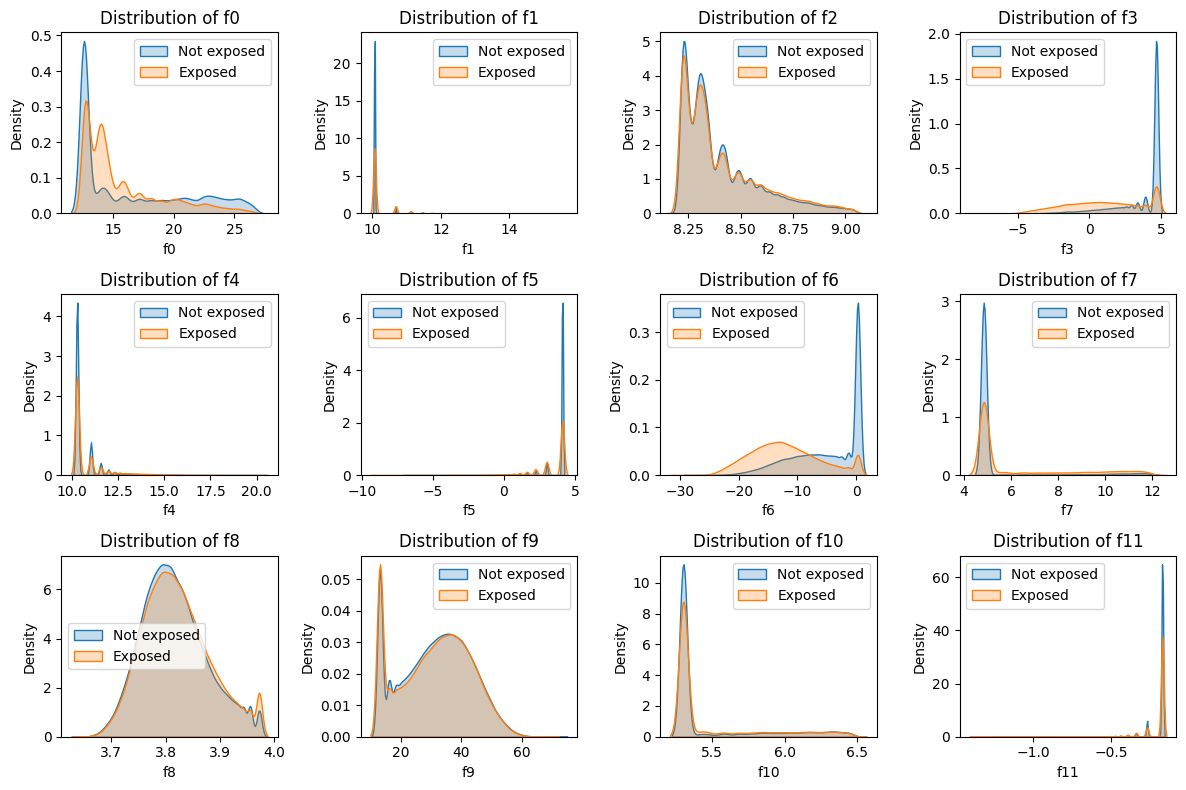

In [ ]:
#  Investigate users designated for treatment but who were not exposed


treated_not_exposed=df_filtered[(df_filtered.treatment==1) & (df_filtered.exposure==0)]
exposed=df_filtered[df_filtered.exposure==1]

factors=df_filtered.iloc[:,0:12]
factor_list=factors.columns.tolist()

n_rows=3
n_cols=4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))
axes = axes.flatten()


for i, feature in enumerate(factor_list):
  sns.kdeplot(treated_not_exposed[feature], label='Not exposed', fill=True, ax=axes[i])
  sns.kdeplot(exposed[feature], label='Exposed', fill=True, ax=axes[i])
  axes[i].set_title(f'Distribution of {feature}')
  axes[i].legend()

plt.tight_layout()
plt.show()

All of the factors have very low p-values, giving high confidence in the KS statistic
f2, f4, and f8-f11 all have low KS statistics, implying there is little variation between users were and were not exposed.

f1 implies a small difference between users that were and were not exposed.

f5 and f7 show a moderate difference, and f0, f3, and f6 show the greatest difference, which implies that these specific features likely were factors that resulted in the user being exposed to the treatment.

In [ ]:
# Use Kolmogorov-Smirnov test to check if the distribution of each factor differs for conversion compared to all other users
from scipy.stats import ks_2samp

conversion=df_filtered[df_filtered.conversion==1]
non_conversion=df_filtered[df_filtered.conversion==0]

factors=df_filtered.iloc[:,0:12]
factor_list=factors.columns.tolist()

print('KS Test Results (Conversion vs Non-conversion Population):')
print("-"*50)

ks_stats_population = []
for feature in factor_list:
  stat, p_value = ks_2samp(
      conversion[feature],
      non_conversion[feature])
  ks_stats_population.append((feature, stat))
  print(f'{feature:<5} | KS statistic {stat:.4f} | p-value: {p_value:.4f}')
ks_stats_population=pd.DataFrame(ks_stats_population)
ks_stats_population=ks_stats_population.rename(columns={0:'Feature', 1:'Population'})

KS Test Results (Conversion vs Non-conversion Population):
--------------------------------------------------
f0    | KS statistic 0.1438 | p-value: 0.0000
f1    | KS statistic 0.0956 | p-value: 0.0000
f2    | KS statistic 0.1318 | p-value: 0.0000
f3    | KS statistic 0.2216 | p-value: 0.0000
f4    | KS statistic 0.4743 | p-value: 0.0000
f5    | KS statistic 0.1579 | p-value: 0.0000
f6    | KS statistic 0.2055 | p-value: 0.0000
f7    | KS statistic 0.1579 | p-value: 0.0000
f8    | KS statistic 0.1553 | p-value: 0.0000
f9    | KS statistic 0.1951 | p-value: 0.0000
f10   | KS statistic 0.4715 | p-value: 0.0000
f11   | KS statistic 0.4011 | p-value: 0.0000


In [ ]:
# Use Kolmogorov-Smirnov test to check if the distribution of each factor differs for conversion to exposed users
from scipy.stats import ks_2samp

conversion=df_filtered[df_filtered.conversion==1]
non_conversion=df_filtered[(df_filtered.conversion==0) & (df_filtered.exposure==1)]

factors=df_filtered.iloc[:,0:12]
factor_list=factors.columns.tolist()

print('KS Test Results (Conversion vs Exposed Non-convesrion):')
print("-"*50)

ks_stats_conv_exposed = []
for feature in factor_list:
  stat, p_value = ks_2samp(
      conversion[feature],
      non_conversion[feature])
  ks_stats_conv_exposed.append((feature, stat))
  print(f'{feature:<5} | KS statistic {stat:.4f} | p-value: {p_value:.4f}')
ks_stats_conv_exposed=pd.DataFrame(ks_stats_conv_exposed)
ks_stats_conv_exposed=ks_stats_conv_exposed.rename(columns={0:'Feature', 1:'Exposed Conv'})

KS Test Results (Conversion vs Exposed Non-convesrion):
--------------------------------------------------
f0    | KS statistic 0.1088 | p-value: 0.0000
f1    | KS statistic 0.0143 | p-value: 0.0000
f2    | KS statistic 0.1435 | p-value: 0.0000
f3    | KS statistic 0.1370 | p-value: 0.0000
f4    | KS statistic 0.4602 | p-value: 0.0000
f5    | KS statistic 0.0263 | p-value: 0.0000
f6    | KS statistic 0.1469 | p-value: 0.0000
f7    | KS statistic 0.0352 | p-value: 0.0000
f8    | KS statistic 0.1899 | p-value: 0.0000
f9    | KS statistic 0.2151 | p-value: 0.0000
f10   | KS statistic 0.4602 | p-value: 0.0000
f11   | KS statistic 0.3892 | p-value: 0.0000


In [ ]:
#  Summary of factor distributions
ks_summary=pd.merge(ks_stats_exposed, ks_stats_population, on='Feature')
ks_summary=pd.merge(ks_summary, ks_stats_conv_exposed, on='Feature')
ks_summary

,Feature,Exposed,Population,Exposed Conv
0,f0,0.337710,0.143764,0.108773
1,f1,0.135041,0.095581,0.014255
2,f2,0.023956,0.131808,0.143489
3,f3,0.482803,0.221584,0.136999
4,f4,0.070766,0.474285,0.460247
5,f5,0.257442,0.157914,0.026334
6,f6,0.455624,0.205454,0.146877
7,f7,0.257442,0.157920,0.035166
8,f8,0.031089,0.155264,0.189926
9,f9,0.027831,0.195074,0.215055


In the summary above we see that the distributions for users who were exposed to the treatment as opposed to not had noticably different distributions for f0, f3, and f6. f5 and f7 also showed notable differences. f1 had a small but notable difference, while f2, f4, and f8-f11 did not show notable difference at all

Users who converted compared to the remaining population had different density curves for f4, f10, and f11. The same curves are also different for those who were exposed but did not convert.

For individuals who were exposed, f0, f2, f3, and f6 showed minor variation, while f8 has moderate variation. Similar patterns were also in the population that did not convert, with f3 and f6 showing a larger variance; this is also observed in exposure, which could be a contributing factor (ie. exposure means conversion is more likely).

In conclusion, it appears that f0, f3, and f5-f6 were important for exposure to occur. Once exposure did occur, f4, f10, and f11 were the most important for conversion, followed by f8 and f9, and to a lesser extent f0, f2, f3, and f6.

Plot density distributions for each factor

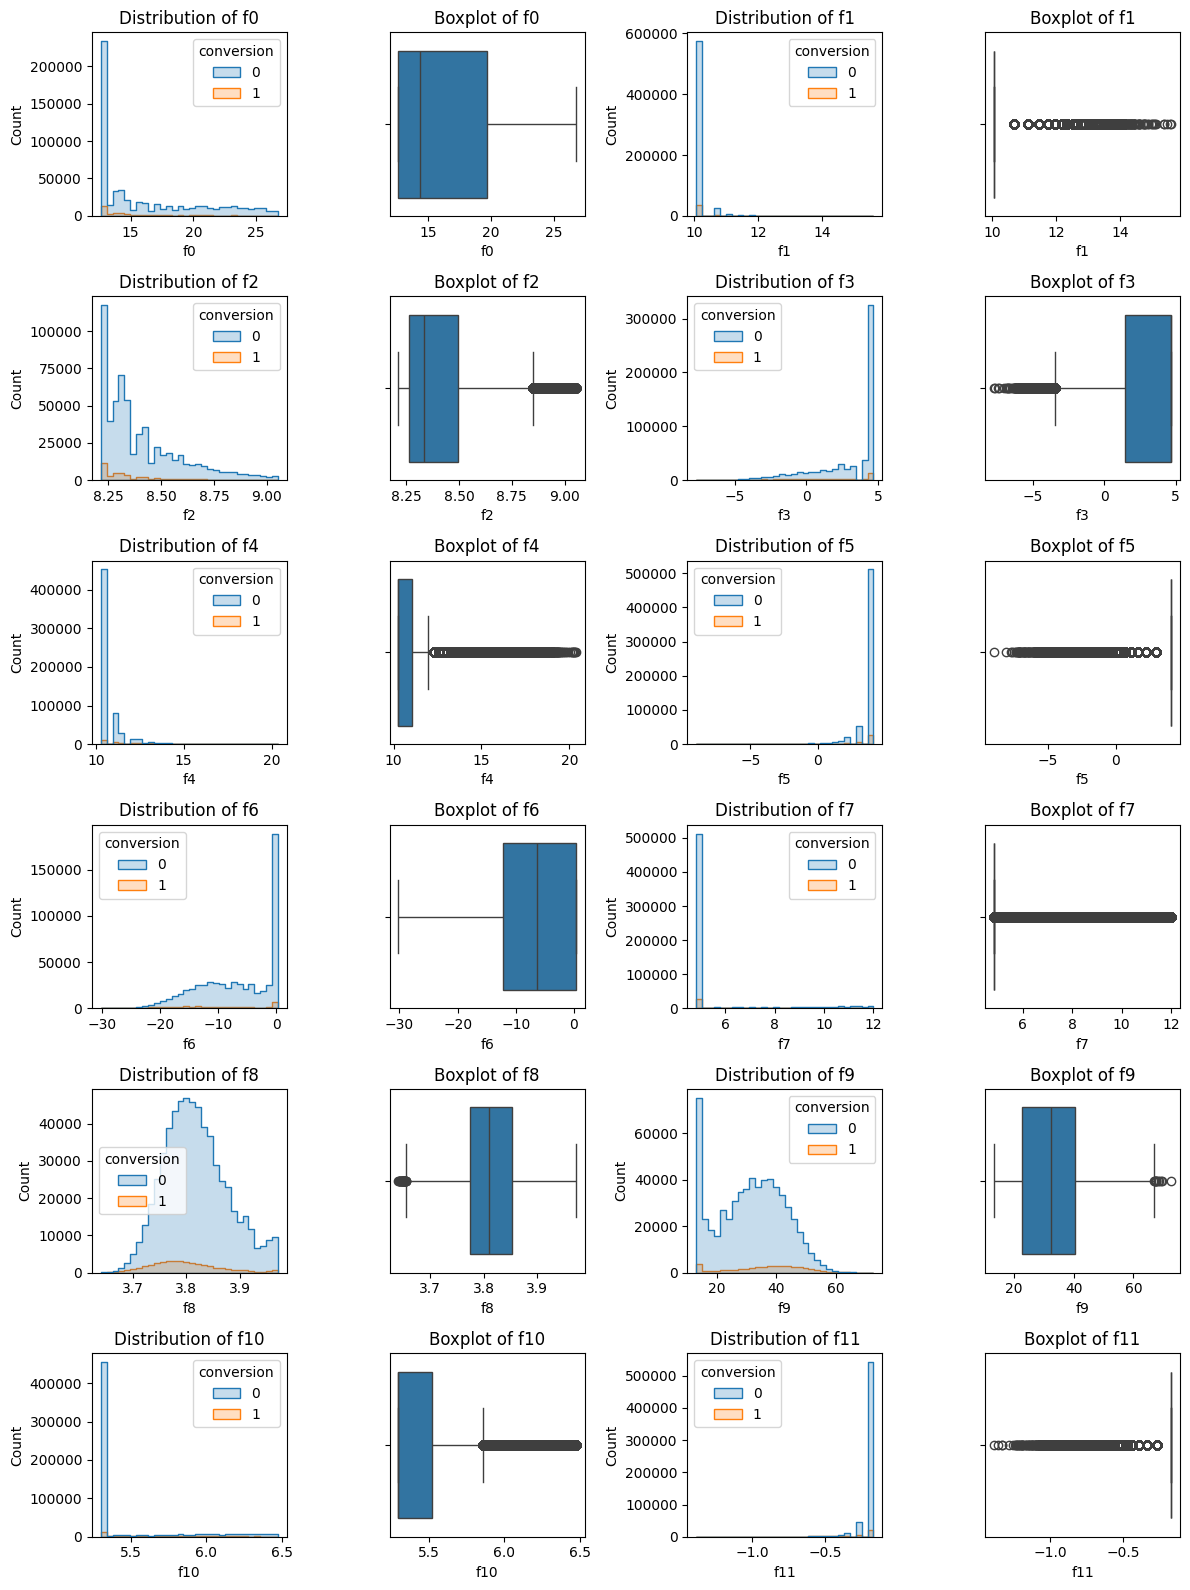

In [ ]:
#  Plot factors to determine distribution
import matplotlib.pyplot as plt
import seaborn as sns

factors=df_filtered.iloc[:,0:12]
factor_list=factors.columns.tolist()

n_rows=6
n_cols=4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 16))
axes = axes.flatten()

for i, feature in enumerate(factor_list):
  # Plot Histogram
  sns.histplot(
      data=df_filtered,
      x=feature,
      hue='conversion',
      kde=False,
      ax=axes[i*2],
      element='step',
      bins=30)
  axes[i*2].set_title(f'Distribution of {feature}')

  # Plot Boxplot
  sns.boxplot(
      x=df_filtered[feature],
      ax=axes[i*2+1],
      data=df_filtered,
      orient='h')
  axes[i*2+1].set_title(f'Boxplot of {feature}')


plt.tight_layout()
plt.show()

Factor Observations

The majority of the the features appear to have a mode at the far right or far left of the data, in some cases with the entire box (interquartile range) and whiskers located on a single value. Only f2, f8 and f9 have whiskers on both sides of the boxes. Outside of these three factors, it appears that the remaining factors are skewed one way or another. In many cases, the factors are so heavily weighted on the left or right limit that some or all of the remaining inputs are outliers.

In [ ]:
#  Summary of total unique values, count of most frequent values
factors=['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']
unique=[]
most_frequent=[]
total_most_frequent=[]
percent_total=[]
total=df_filtered.shape[0]

for col in ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']:
  unique.append(df_filtered[col].nunique())
  most_frequent.append(df_filtered[col].value_counts().index[0])
  total_most_frequent.append(df_filtered[col].value_counts().iloc[0])
  percent_total.append(round(df_filtered[col].value_counts().iloc[0]/total, 4))

print(f'Summary of unique values, most frequent values, counts of most frequent values, and proportion of most frequent value:')

unique_df=pd.concat([pd.Series(factors),pd.Series(unique), pd.Series(most_frequent), pd.Series(total_most_frequent), pd.Series(percent_total)], axis=1)
unique_df.columns=['Factor','Unique', 'Most Frequent', 'Total Most Frequent','Proportion Total']
unique_df=unique_df.sort_values(by='Total Most Frequent', ascending=False).reset_index(drop=True)
unique_df

Summary of unique values, most frequent values, and counts of most frequent values:


,Factor,Unique,Most Frequent,Total Most Frequent,Proportion Total
0,f1,53,10.059654,608914,0.9323
1,f11,121,-0.168679,562507,0.8612
2,f5,117,4.115453,538233,0.8240
3,f7,111323,4.833815,538233,0.8240
4,f10,176662,5.300375,462970,0.7088
5,f4,230,10.280525,462970,0.7088
6,f3,498,4.679882,337981,0.5175
7,f0,332928,12.616364,195678,0.2996
8,f6,1451,0.294443,195678,0.2996
9,f9,1517,13.190056,79136,0.1212


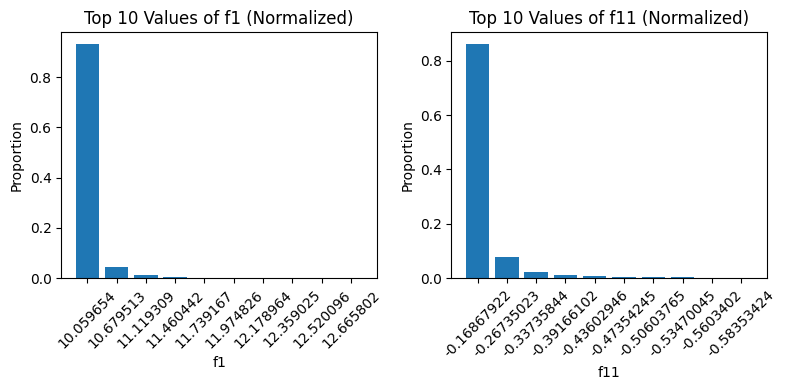

In [ ]:
# Zoom in to distributions for f1 and f11

f1_counts = df_filtered['f1'].value_counts(normalize=True).head(10)
f11_counts = df_filtered['f11'].value_counts(normalize=True).head(10)
plt.figure(figsize=(8, 4))


plt.subplot(1, 2, 1)
plt.bar(f1_counts.index.astype(str), f1_counts.values)
plt.title('Top 10 Values of f1 (Normalized)')
plt.xlabel('f1')
plt.ylabel('Proportion')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(f11_counts.index.astype(str), f11_counts.values)
plt.title('Top 10 Values of f11 (Normalized)')
plt.xlabel('f11')
plt.ylabel('Proportion')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

f1 and f11 have high proportions of their mode value; 0.93 and 0.86 respectivly, which will require consideration when creating models.

There are four cases where two features have the same total number of unique values, with one having a significantly smaller total of unique values than the other, suggesting that the feature with the smaller number of unique values is a transform of the other.

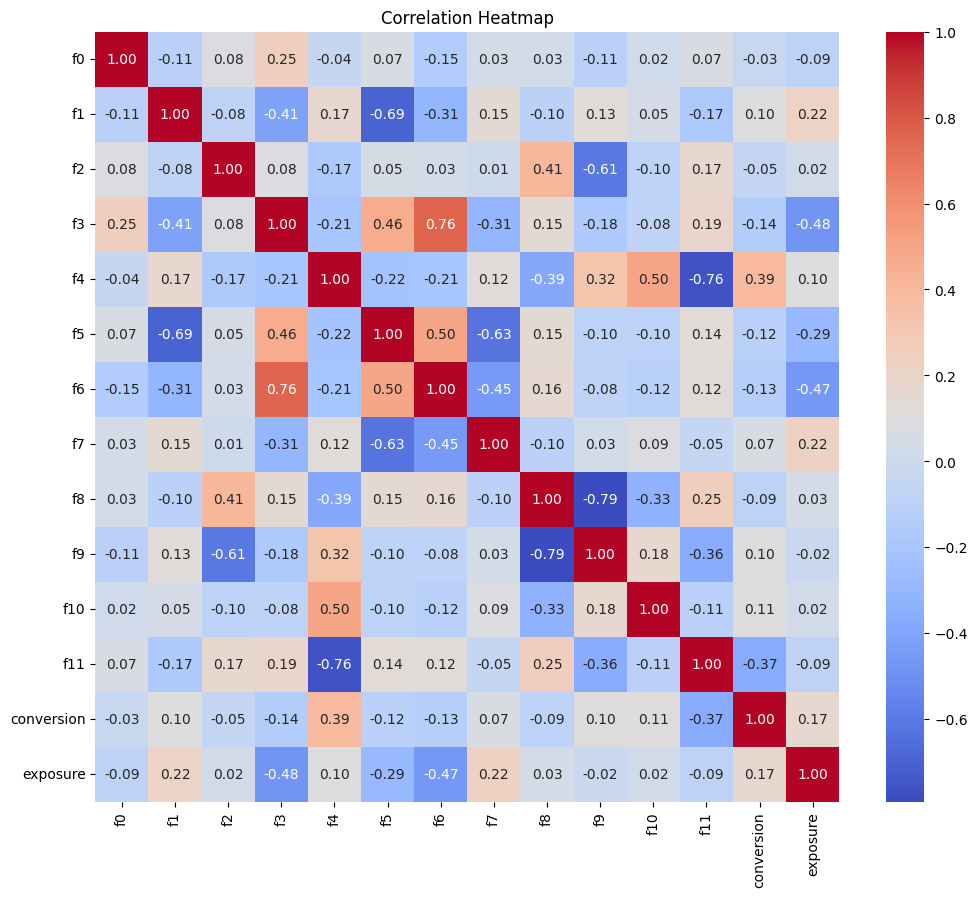

In [ ]:
# Create a correlation heatmap of the data
# Create a correlation heatmap of the data

plt.figure(figsize=(12, 10))
sns.heatmap(df_filtered.drop(columns=('treatment')).corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Conversion has the heaviest correlation with f4 at 0.39, followed by f11 at -0.37.  f4 shows a relation with f10, both having their mode value in the same rows, potentially being a transformed version of f10, however, f10 has a correlation of 0.11.

Exposure has the greatest correlation with f3 at -0.48 and f6 with -0.47.  f6 shows a relation with f0, both having their mode value in the same rows, however, as with f4 and f10, f0 has a much smaller correlation with exposure.

f4 and f6 both have significantly fewer unique values then their relation features, indicating the possibility that f4 and f6 are the result of feature engineering or transforms that allowed them to become more relevant in a linear model.

In addition to these observations, f4 and f11 have a very high correlation of -0.76; f8 and f9 of -0.79; f1 and f5 -0.61; f5 and f7 -0.63, f2 and f9 -0.61; f3 and f6 0.76, implying similar linear movement.

In [ ]:
# Determine if f5 and f7 have their mode value in the same rows
f5_mode = df_filtered['f5'].mode()[0]
f7_mode = df_filtered['f7'].mode()[0]


f5_mask = df_filtered['f5'] == f5_mode
f7_mask = df_filtered['f7'] == f7_mode

both_match = (f5_mask & f7_mask).sum()

either_match = (f5_mask | f7_mask).sum()

overlap_pct = both_match / f5_mask.sum()

print(f"Rows where both f5 and f7 are at their mode: {both_match}")
print(f"Rows where f5 is at mode: {f5_mask.sum()}")
print(f"Rows where f7 is at mode: {f7_mask.sum()}")
print(f"Percentage of f5-mode rows that are also f7-mode rows: {overlap_pct:.2%}")

Rows where both f5 and f7 are at their mode: 538233
Rows where f5 is at mode: 538233
Rows where f7 is at mode: 538233
Percentage of f5-mode rows that are also f7-mode rows: 100.00%


In [ ]:
#  Determine how well f7 explains f5
model = DecisionTreeRegressor(max_depth=4)
model.fit(df_filtered[['f7']], df_filtered['f5'])
print("R-squared:", model.score(df_filtered[['f7']], df_filtered['f5']))

R-squared: 0.7095298272576481


In [ ]:
# Determine if f4 and f10 have their mode value in the same rows
f10_mode = df_filtered['f10'].mode()[0]
f4_mode = df_filtered['f4'].mode()[0]

f10_mask = df_filtered['f10'] == f10_mode
f4_mask = df_filtered['f4'] == f4_mode

both_match = (f10_mask & f4_mask).sum()
overlap_pct = both_match / f10_mask.sum()

print(f"[f10/f4] Rows where both are at mode: {both_match}")
print(f"f10-mode rows: {f10_mask.sum()}")
print(f"f4-mode rows: {f4_mask.sum()}")
print(f"Overlap (f10-mode also f4-mode): {overlap_pct:.2%}")

[f10/f4] Rows where both are at mode: 462970
f10-mode rows: 462970
f4-mode rows: 462970
Overlap (f10-mode also f4-mode): 100.00%


In [ ]:
#  Determine how well f10 explains f4
model = DecisionTreeRegressor(max_depth=4)
model.fit(df_filtered[['f10']], df_filtered['f4'])
print("R-squared:", model.score(df_filtered[['f10']], df_filtered['f4']))

R-squared: 0.6318624849042245


In [ ]:
# Determine if f0 and f6 have their mode value in the same rows
f0_mode = df_filtered['f0'].mode()[0]
f6_mode = df_filtered['f6'].mode()[0]

f0_mask = df_filtered['f0'] == f0_mode
f6_mask = df_filtered['f6'] == f6_mode

both_match = (f0_mask & f6_mask).sum()
overlap_pct = both_match / f0_mask.sum()

print(f"[f0/f6] Rows where both are at mode: {both_match}")
print(f"f0-mode rows: {f0_mask.sum()}")
print(f"f6-mode rows: {f6_mask.sum()}")
print(f"Overlap (f0-mode also f6-mode): {overlap_pct:.2%}")

[f0/f6] Rows where both are at mode: 195678
f0-mode rows: 195678
f6-mode rows: 195678
Overlap (f0-mode also f6-mode): 100.00%


In [ ]:
#  Determine how well f0 explains f6
model = DecisionTreeRegressor(max_depth=4)
model.fit(df_filtered[['f0']], df_filtered['f6'])
print("R-squared:", model.score(df_filtered[['f0']], df_filtered['f6']))

R-squared: 0.6323060487546326


In [ ]:
# Determine if f2 and f8 have their mode value in the same rows
f2_mode = df_filtered['f2'].mode()[0]
f8_mode = df_filtered['f8'].mode()[0]

f2_mask = df_filtered['f2'] == f2_mode
f8_mask = df_filtered['f8'] == f8_mode

both_match = (f2_mask & f8_mask).sum()
overlap_pct = both_match / f2_mask.sum()

print(f"[f2/f8] Rows where both are at mode: {both_match}")
print(f"f2-mode rows: {f2_mask.sum()}")
print(f"f8-mode rows: {f8_mask.sum()}")
print(f"Overlap (f2-mode also f8-mode): {overlap_pct:.2%}")

[f2/f8] Rows where both are at mode: 10270
f2-mode rows: 10270
f8-mode rows: 10270
Overlap (f2-mode also f8-mode): 100.00%


In [ ]:
#  Determine how well f2 explains f8
model = DecisionTreeRegressor(max_depth=4)
model.fit(df_filtered[['f2']], df_filtered['f8'])
print("R-squared:", model.score(df_filtered[['f2']], df_filtered['f8']))

R-squared: 0.3156047484627337


Examining the heatmap of the coorelation heat map, and the relationship between factors that have the same count of the most frequent value:

f5 and f7 have a strong inverse corellation of -0.63, potentially the same data with different encoding.  f7 explains 70% of the variance in f5, indicating it is a main driver in the value.

f4 and f10 have a moderate correlation of 0.50, suggesting overlap.  f10 explains 63% of the variance in f4, indicating it is a main driver in the value.

f2 and f8 have a mild correlation of 0.41, indicating possible relationship or complimentary relations.  f2 explains 32% of the variance in f8, indicating it may be a partial contributor but not a dominant one.

f0 and f6 have a low correlation of -0.15, indicating they are distinct, however  f0 explains 63% of the variance in f6, indicating it is a main driver in the value.

Each pair shows it's mode value in the same rows of the raw data 100% of the time, which will be considered when preparing the data set for modelling.